Instituto Federal de Santa Catarina  
Curso de Engenharia Eletrônica  
Disciplina: Sistemas de Controle II  
Estudante: Jade Dutra Lopes  
22 de junho de 2023

## Projeto 2 - Controle Digital

In [1]:
from numpy import matrix, eye, linspace, array, zeros, zeros_like, transpose, sqrt, conjugate, block, argmax
from numpy.linalg import matrix_rank
from control import tf, ss, ss2tf, tfdata, step_response, pole, zero, minreal
from control.matlab import acker, lsim
from numpy import linalg
from math import e, pi, pow, log
from scipy.linalg import eig
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
import math
import cmath
import control
import control.matlab

def root2poly(symbol, *roots):
 x = sp.symbols(str(symbol));
 poly = 1;
 for root in roots:
     poly *=(x-root);
 return poly.expand();


NT = len("JadeDutraLopes")
R1 = 2000*NT
R2 = 18000
C1 = 100e-9
C2 = 680e-9

#R1 = 34e3
#R2 = 18e3
#C1 = 78e-9
#C2 = 680e-9

# último número da matrícula = 4; variáveis de estado: ve1, vx

### Matrizes

In [2]:
A = matrix([[-1/(R2*C1), 1/(R2*C1)], [-1/(R2*C1) + 1/(R2*C2), -1/(R1*C2) + 1/(R2*C1) - 1/(R2*C2)]])
B = matrix([[0], [1/(R1*C2)]])
C =  matrix('1, 0')
D = matrix('0')

#sistema de estados
G = ss(A,B,C,D)
G

StateSpace(array([[-555.55555556,  555.55555556],
       [-473.85620915,  421.33520075]]), array([[ 0.       ],
       [52.5210084]]), array([[1., 0.]]), array([[0.]]))

In [3]:
print(A)

[[-555.55555556  555.55555556]
 [-473.85620915  421.33520075]]


In [4]:
sys = ss2tf(G)
sys

TransferFunction(array([5.68434189e-14, 2.91783380e+04]), array([1.00000000e+00, 1.34220355e+02, 2.91783380e+04]))

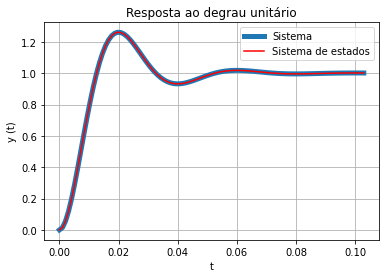

In [5]:
x, y = step_response(sys)
x2, y2 = step_response(G)
plt.figure()
plt.plot(x, y,  linewidth=5, label='Sistema')
plt.plot(x2, y2, 'r', label='Sistema de estados')
plt.title("Resposta ao degrau unitário")
plt.xlabel("t")
plt.ylabel("y (t)")
plt.legend()
plt.grid(True)
plt.show()

In [6]:
p = pole(G)
print(f'Pólos de G(s) = {p} ')

s1 = p[0]

# Frequência Amortecida
wd = s1.imag

# Frequência Amostrada
wa = 15 * wd

# Período
T = 2*pi/wa

print(f'T = {T*1e3:.2f} ms')

tfinal = 100*T

Pólos de G(s) = [-67.1101774+157.08138684j -67.1101774-157.08138684j] 
T = 2.67 ms


### Equações Recursivas

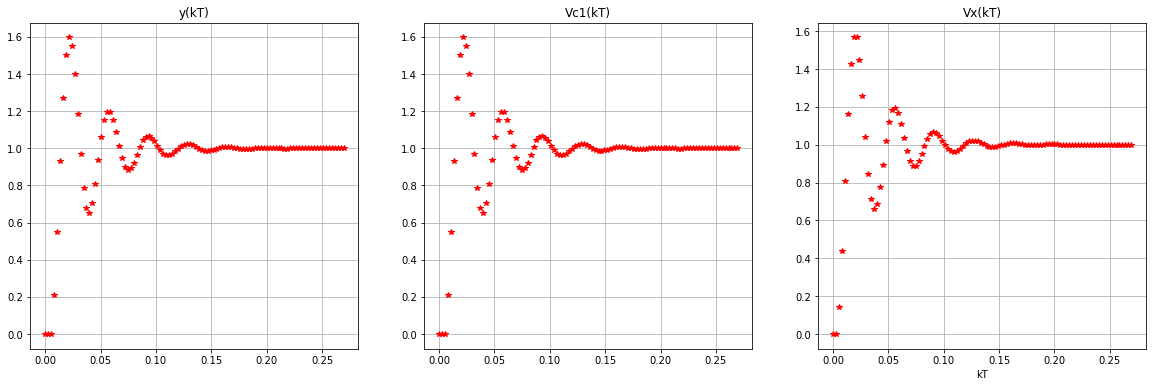

In [7]:
kmax = int(tfinal/T + 1)
k = linspace(0, kmax, kmax+1)
u = array([1.0]*len(k))       #degrau
 
x = matrix([zeros_like(k), zeros_like(k)])
x_p = zeros_like(x)

y = zeros_like(k)

for i in range (1, len(k)):
    x[:, i] = T*x_p[:, i-1] + x[:, i-1]
    
    x_p[:, i] = A*x[:, i] + B*u[i]
    y[i] = C*x[:, i] + D*u[i]
       
f, [Y, X1, X2] = plt.subplots(1, 3, figsize= [20, 6])

X1.plot(k*T, transpose(x[0, :]),'r*')
X1.set_title("Vc1(kT)")
plt.xlabel("kT")
X1.grid()

X2.plot(k*T, transpose(x[1, :]), 'r*')
X2.set_title("Vx(kT)")
plt.xlabel("kT")
X2.grid()


Y.plot(k*T, y, 'r*');
Y.set_title("y(kT)")
plt.xlabel("kT")
Y.grid()

plt.show()

### Requerimentos do projeto

In [8]:
Ts5 = NT*1e-3
Mp = (2*len('Jade'))/100
print(f'Ts 5% = {(Ts5*1e3):.4} ms  | Mp = {Mp:.1%}')

Ts 5% = 14.0 ms  | Mp = 8.0%


In [9]:
zeta = sqrt(pow(log(Mp),2)/(pow(pi, 2) + pow(log(Mp),2)))

wn = 3/(zeta*Ts5)

print(f'zeta = {zeta:.4f} | wn = {wn:.4f}')

wd = wn*sqrt(1-zeta**2)
wa = 15*wd

T = 2*pi/wa

print(f'wd = {wd:.4f} | wa = {wa:.4f} | T = {T*1e3:.4f} ms')

zeta = 0.6266 | wn = 341.9941
wd = 266.5363 | wa = 3998.0448 | T = 1.5716 ms


### Novos pólos dominantes

In [10]:
s1_ = -zeta*wn + 1j*wd
s2_ = -zeta*wn - 1j*wd
s3_ = -5*zeta*wn

print(s1_)
print(s2_)
print(s3_)

(-214.28571428571428+266.536323007738j)
(-214.28571428571428-266.536323007738j)
-1071.4285714285713


In [11]:
eq_des = np.poly([s1_, s2_, s3_]);
eq_des

array([1.00000000e+00, 1.50000000e+03, 5.76143652e+05, 1.25314263e+08])

### Ganhos e Controlabilidade

In [12]:
t = np.linspace(0, tfinal, 1000) 
A_c = block([[A, zeros((2, 1))], [-C, 0]])
B_c = block([[B], [0]])

Mc = block([[A, B], [-C, 0]])

print(f'É controlável? {matrix_rank(A)} + 1 = {matrix_rank(Mc)}')

K_c = acker(A_c, B_c, [s1_, s2_, s3_])
auVa, auVe = eig(A_c-B_c*K_c)

print(f'Autovalores = {auVa}')

K = matrix([K_c[0, 0], K_c[0 ,1]])
Ki = matrix([-K_c[0, 2]])
print(f'K^ = {K_c}\nK = {K}\nKi = {Ki}')

AA = block([[A-B*K, B+Ki], [-C, 0]])
BB = matrix([[0], [0], [1]])
CC = matrix([1, 0, 0])
DD = matrix([0])

FTMF = ss(AA, BB, CC, DD)
Y, t, X = lsim(FTMF, [1]*len(t), t, matrix('[0;0;0]'))

É controlável? 2 + 1 = 3
Autovalores = [ -214.28571429+266.53632301j  -214.28571429-266.53632301j
 -1071.42857143  +0.j        ]
K^ = [[   -7.25884919    26.00444444 -4294.77042262]]
K = [[-7.25884919 26.00444444]]
Ki = [[4294.77042262]]


### Observador de Ordem Miníma

In [13]:
# Resposta ao degrau

u = np.ones(len(t));
ystep, t, X = control.matlab.lsim(G,u,t);

# separando os elemntos do vetor X
x1step = X[:,0];
x2step = X[:,1];

In [14]:
autovalores_planta, autovetores = linalg.eig(A);
p = autovalores_planta
p

array([-67.1101774+157.08138684j, -67.1101774-157.08138684j])

In [15]:
Abb = A[1,1]
Aab = A[0,1]
L = -5*abs(p[1]);
# Ganho 
Ke = control.acker(Abb,Aab,[L])
Ke = Ke[0,0]      # Transformando em escalar

Aaa = A[0,0];
Aba = A[1,0];
Ba = B[0,0];
Bb = B[1,0];

Achapeu = Abb-Ke*Aab;
Bchapeu = Achapeu*Ke+Aba-Ke*Aaa;
Fchapeu = Bb-Ke*Ba;

Cchapeu = np.matrix('0 ; 1');
Dchapeu = np.block([[1], [Ke]]);

print("L: " + str(L) + "\n")
print("Ke: " + str(Ke) + "\n")
print("Achapeu: " + str(Achapeu) + "\n")
print("Bchapeu: " + str(Bchapeu) + "\n")
print("Fchapeu: " + str(Fchapeu) + "\n")
print("Cchapeu: " + str(Cchapeu) + "\n")
print("Dchapeu: " + str(Dchapeu) + "\n")

# Matriz de Controlabilidade do sistema dual para ordem mínima
Mc = control.ctrb(Aab,Abb)

# Teste de Controlabilidade
rank_Mc = np.linalg.matrix_rank(Mc) # número de postos do sistema
print(rank_Mc)
print('A matriz é observável')


L: -854.0833975945703

Ke: 2.2957534770147645

Achapeu: -854.0833975945702

Bchapeu: -1159.2025404971089

Fchapeu: 52.52100840336135

Cchapeu: [[0]
 [1]]

Dchapeu: [[1.        ]
 [2.29575348]]

1
A matriz é observável


In [16]:
# simulação com equações recursivas
# definindo o intervalo de simulação e o vetor de entrada
Fs = 2000
T = 1/Fs;
tfinal = 0.2;
Kmax = int(tfinal/T+1);
k = np.linspace(0, Kmax, int(Fs*tfinal))
u = np.ones(len(k));

# definindo os vetores
x1 = np.zeros(len(k));
x2 = np.zeros(len(k));
x1_ponto = np.zeros(len(k));
x2_ponto = np.zeros(len(k));
y = np.zeros(len(k));
eta1 = np.zeros(len(k));
eta1_ponto = np.zeros(len(k));
xtil1 = np.zeros(len(k));
xtil2 = np.zeros(len(k));

# condições iniciais (podem ser diferentes de zero)
x1[0] = 0;  #  para k = 0
x2[0] = 0;  #  para k = 0
x1_ponto[0] = 0;  #  para k = 0
x2_ponto[0] = 0;  #  para k = 0
y[0] = C[0,0]*x1[0]+C[0,1]*x2[0]+D*u[0];  #  para k = 0
eta1[0] = 0;  #  para k = 0
eta1_ponto[0] = Fchapeu*u[0];  #  para k = 0



for j in range(1,Kmax-1):
    # sistema original
        # Equações dos integradores
        x1[j]=T*x1_ponto[j-1]+x1[j-1];
        x2[j]=T*x2_ponto[j-1]+x2[j-1];    
        
        # Equação diferencial de estados:  Xponto=A*X+B*U
        x1_ponto[j]=A[0,0]*x1[j]+A[0,1]*x2[j]+B[0]*u[j];  
        x2_ponto[j]=A[1,0]*x1[j]+A[1,1]*x2[j]+B[1]*u[j]; 

        # Equação de Saída: Y=C*X+D*U
        y[j] = C[0,0]*x1[j]+C[0,1]*x2[j]+D*u[j];

    # observador de ordem mínima
        # Equações dos integradores do observador
        eta1[j]=T*eta1_ponto[j-1]+eta1[j-1];
    
        # Equação diferencial de estados do observador
        eta1_ponto[j]=Achapeu*eta1[j]+Bchapeu*y[j]+Fchapeu*u[j];
    
    # Transformação
        # equação de saída do observador de ordem mínima
        xtil1[j]=Cchapeu[0,0]*eta1[j]+Dchapeu[0]*y[j];
        xtil2[j]=Cchapeu[1,0]*eta1[j]+Dchapeu[1]*y[j];

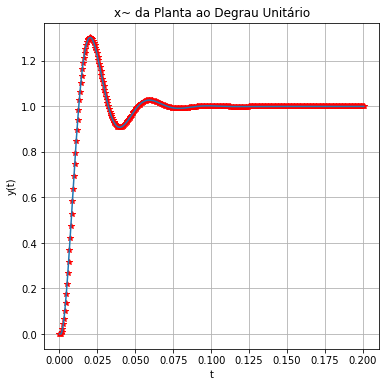

In [17]:
# resposta para entrada ao degrau
fig, ((ax1) ) = plt.subplots(1, 1)
fig.set_size_inches(6,6)

ax1.plot(k*T, xtil1, 'r*', k*T, x1)
ax1.set_title("x~ da Planta ao Degrau Unitário")
ax1.set_xlabel("t")
ax1.set_ylabel("y(t)")

ax1.grid(True,'both')

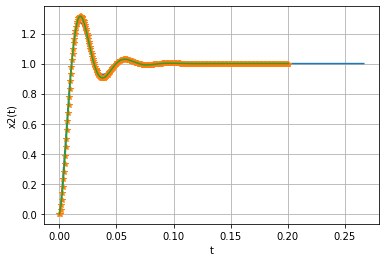

In [18]:
plt.figure()
plt.plot(t, x2step,k*T,x2,'*',k*T,xtil2)
plt.xlabel("t")
plt.ylabel("x2(t)")
plt.grid(True)
plt.show()

### Resposta para entrada ao degrau do sistema controlado

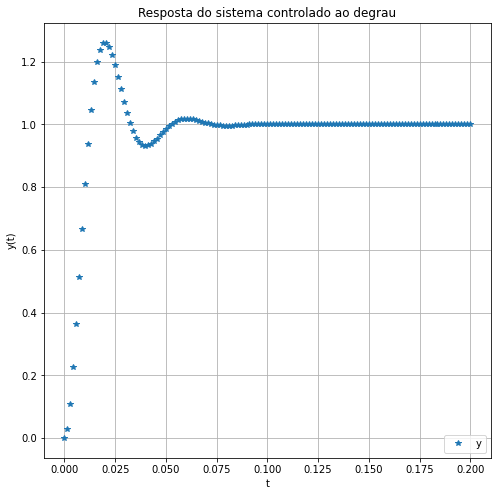

In [19]:
tfinal = 0.2
Y_ctrld, t_y_ctrld = control.matlab.step(G,tfinal);

fig, ((ax1) ) = plt.subplots(1, 1)
fig.set_size_inches(8,8)

ax1.plot(t_y_ctrld,Y_ctrld,'*')
ax1.set_title("Resposta do sistema controlado ao degrau")
ax1.set_xlabel("t")
ax1.set_ylabel("y(t)")
ax1.legend(['y'],loc="lower right")
ax1.grid(True,'both')

### Mp e Ts5% controlados

In [20]:
Mp = (max(Y_ctrld)-Y_ctrld[-1])/(Y_ctrld[-1]-Y_ctrld[0]);
print("\nMp medido = ",Mp)

j = len(t_y_ctrld)-1;
delta = 0;
while (delta < 0.05):
    delta = abs((Y_ctrld[j]-Y_ctrld[-1])/Y_ctrld[-1]);
    ts = t_y_ctrld[j];
    j = j-1;
    
print("\n Ts 5% medido = \n",ts)


Mp medido =  0.25999030088832875

 Ts 5% medido = 
 0.044117647058823525


In [ ]:
#eq. recursivas

#t = t_y_ctrld


Fs = Fs*10
Ts = 1/Fs
tfinal = 0.05;

Kmax = int((tfinal/Ts)+1);

t =np.linspace(0, tfinal, Kmax);
r = np.ones(len(t));
r[0] = 0;

# declaração dos vetores
x1 = np.zeros(len(t));
x2 = np.zeros(len(t));
csi = np.zeros(len(t));

u = np.zeros(len(t));

x1_ponto = np.zeros(len(t));
x2_ponto = np.zeros(len(t));
csi_ponto = np.zeros(len(t));
y = np.zeros(len(t));

y[0] = C[0,0]*x1[0]+C[0,1]*x2[0]+D*u[0];  #  para k = 0

for j in range(0,len(t)):
    # Equações dos integradores
    x1[j] = Ts*x1_ponto[j-1] + x1[j-1];
    x2[j] = Ts*x2_ponto[j-1] + x2[j-1];    
    csi[j] = Ts*csi_ponto[j-1] + csi[j-1];

    # Equação da lei de controle
    u[j] = -(K[0]*xtil1[j] + K[1]*xtil2[j]) + Ki*csi[j];

    # Equação diferencial de estados:  Xponto=A*X+B*U
    x1_ponto[j] = A[0,0]*x1[j] + A[0,1]*x2[j] + B[0]*u[j];  
    x2_ponto[j] = A[1,0]*x1[j] + A[1,1]*x2[j] + B[1]*u[j]; 

    # Equação de Saída: Y=C*X+D*U
    y[j] = C[0,0]*x1[j]# + C[1]*x2[j]# + D*u[j];

    # Equação de erro
    csi_ponto[j] = r[j] - y[j];